In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import os
import re
from scipy.optimize import curve_fit

from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

Load the raw XEB result data from the IBM Q run.

In [2]:
[xeb50, xeb100, xeb500, xeb1000, xeb5000] = np.load('data/ibmq_manila/xebcounts.npy')

def discard_odd(full):
    full = np.array(full)
    return np.hstack((full[:,0:44:2,:], full[:,44:,]))

[xeb50, xeb100, xeb500, xeb1000, xeb5000] = [discard_odd(counts) for counts in [xeb50, xeb100, xeb500, xeb1000, xeb5000]]
xeb_results = {
    50: xeb50,
    100: xeb100,
    500: xeb500,
    1000: xeb1000,
    5000: xeb5000,
}

shots_per_run = 50
run_count = xeb_results[shots_per_run].shape[0]
xeb_results[shots_per_run].shape

(10, 50, 4)

Load the ideal simulated results of the XEB sequences.

In [3]:
simulated_results_xeb = np.loadtxt('data/simulated_results_xeb.txt', dtype=int)
simulated_results_xeb = np.vstack((simulated_results_xeb[0:44:2,:], simulated_results_xeb[44:,:]))
simulated_results_xeb = simulated_results_xeb / 1e6
simulated_results_xeb.shape

(50, 4)

Set up our circuit results as `records`, a list of dictionaries with the following fields:
- `circuit_i`: circuit index
- `jaqal`: the JAQAL code of the circuit
- `cycle_depth`: total 2Q gate count of circuit (number of layers)
- `pure_probs`: list of ideal probabilities by basis state
- `sampled_probs`: list of measured probabilities by basis state

In [4]:
def get_2Q_gate_count(jaqal):
    code_array = jaqal.split("\n")
    code_array = code_array[5:-1]
    total_2q_gate_count = 0
    for rotation in code_array:
        rotation_array = rotation.split(" ")
        gate_type = rotation_array[0]
        if gate_type.startswith("MS"):
            total_2q_gate_count += 1
    return total_2q_gate_count

def files_to_list(directory):
    jaqal_files = [f'{directory}/{f}' for f in os.listdir(directory)]
    jaqal_circuits = []
    for jaqal_file in jaqal_files:
        with open(jaqal_file, mode='r') as f:
            jaqal = ''.join(f.readlines())
            circuit_i = int(re.search('xeb\/(.*)_1.txt', jaqal_file).group(1))
            circuit_i = (circuit_i // 2) - 1  # convert circuit_i to an index between 0 and 49
            assert 0 <= circuit_i and circuit_i <= 49
            total_2q_gate_count = get_2Q_gate_count(jaqal)
            pure_probs = simulated_results_xeb[circuit_i]
            sampled_probs = xeb_results[shots_per_run][:,circuit_i,:]/shots_per_run
            jaqal_circuits.append({
                'circuit_i': circuit_i,
                'jaqal': jaqal,
                'cycle_depth': total_2q_gate_count,
                'pure_probs': pure_probs,
                'sampled_probs': sampled_probs,
            })
    return jaqal_circuits

dir_name = "data/sequences/xeb"
records = files_to_list(dir_name)
print(f'imported {len(records)} circuits from {dir_name}')

imported 50 circuits from data/sequences/xeb


for gaussian, reduced_chi_square = 17.83703920118497
for exponential, reduced_chi_square = 4.755093071251966
K=50, run_count=10


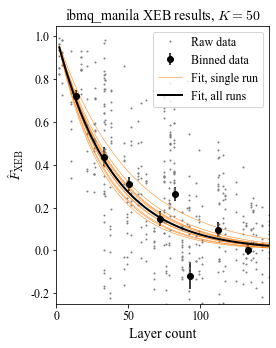

In [5]:
DIM = 4   # 2-qubit circuits

records_by_run = [copy.deepcopy(records) for _ in range(run_count)]

for run_idx, records in enumerate(records_by_run):
    for record in records:
        e_u = np.sum(record['pure_probs']**2)
        u_u = np.sum(record['pure_probs']) / DIM
        m_u = np.sum(record['pure_probs'] * record['sampled_probs'][run_idx])
        record.update(
            sampled_probs=record['sampled_probs'][run_idx],
            e_u=e_u,
            u_u=u_u,
            m_u=m_u,
        )
        
def gaussian_func(x, alpha):
    return alpha**(x**2)

def exponential_func(x, alpha):
    return alpha**(x)

xeb_fidelities = []

all_success_rates = []
total_layer_counts = None

plt.figure(figsize=(4,5))

for run_idx, records in enumerate(records_by_run):

    # ignore run ranges that we observe to have abnormalities     
    if shots_per_run == 500 and run_idx in [5,6,7]:
        continue
    if shots_per_run == 1000 and run_idx in [8,9]:
        continue
    
    success_rates = []
    for record in records:
        e_u = np.sum(record["pure_probs"]**2)
        u_u = np.sum(record["pure_probs"]) / DIM
        m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
        y = m_u - u_u
        x = e_u - u_u
        xeb_fidelity = (x * y) / (x ** 2)
        success_rates.append(xeb_fidelity)
    all_success_rates.append(success_rates)
    total_layer_counts = [record["cycle_depth"] for record in records]

    x_XEB = np.linspace(min(total_layer_counts),max(total_layer_counts),100)
    popt_XEB, pcov = curve_fit(exponential_func, total_layer_counts, success_rates, p0=[1])
    plt.plot(total_layer_counts, success_rates,
        marker='.',
        linestyle='',
        color='gray',
        markersize=2,
        label='Raw data' if run_idx == 0 else None)
    
    alpha_XEB = popt_XEB[0]
    xeb_fidelities.append(alpha_XEB)
    
    plt.plot(x_XEB, exponential_func(x_XEB, alpha_XEB), linewidth=0.5,
             color='C1', label='Fit, single run' if run_idx == 0 else None)
    
    plt.ylabel(r'$\hat{F}_{\rm XEB}}$', fontsize=14)
    plt.xlabel('Layer count', fontsize=14)
    plt.ylim(-0.25, 1.05)
    ax = plt.gca()
    plt.tick_params(axis='y', which='minor')
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
##########   
# Plot binned data and calculate reduced chi-square
# for Gaussian and exponential fits
sorted_all_success_rates = np.array(all_success_rates)[:,np.array(total_layer_counts).argsort()]
sorted_total_layer_counts = np.array(sorted(total_layer_counts))
all_points = []
for i,x in enumerate(sorted_total_layer_counts):
    all_points.extend([(x,y) for y in sorted_all_success_rates[:,i]])
n_points = len(all_points)
all_points = np.array(all_points)

n_runs = len(xeb_fidelities)
bin_size = n_runs*6
x_bin = np.array([np.mean(all_points[i:i+bin_size,0]) for i in range(0, n_points-(n_points%bin_size), bin_size)])
y_bin = np.array([np.mean(all_points[i:i+bin_size,1]) for i in range(0, n_points-(n_points%bin_size), bin_size)])
y_bin_stderr = np.array([np.std(all_points[i:i+bin_size,1])/np.sqrt(bin_size) for i in range(0, n_points-(n_points%bin_size), bin_size)])
plt.errorbar(x_bin, y_bin, yerr=y_bin_stderr, marker='o', linestyle='', label='Binned data', color='k')

popt, pcov = curve_fit(gaussian_func, x_bin, y_bin)
y_fit_gaussian = gaussian_func(x_bin, *popt)
chi_square = np.sum((y_bin - y_fit_gaussian)**2 / y_bin_stderr**2)
dof = len(y_bin) - len(popt)
reduced_chi_square = chi_square / dof
print('for gaussian, reduced_chi_square =', reduced_chi_square)

popt, pcov = curve_fit(exponential_func, x_bin, y_bin)
y_fit_exponential = exponential_func(x_bin, *popt)
chi_square = np.sum((y_bin - y_fit_exponential)**2 / y_bin_stderr**2)
dof = len(y_bin) - len(popt)
reduced_chi_square = chi_square / dof
print('for exponential, reduced_chi_square =', reduced_chi_square)
###############

plt.plot(x_XEB, exponential_func(x_XEB, np.mean(xeb_fidelities)), 'black', linewidth=2, label="Fit, all runs")
plt.title(fr'ibmq_manila XEB results, $K={shots_per_run}$', fontsize=14)
plt.xlim(0, max(x_XEB))
print(f'K={shots_per_run}, run_count={run_count}')

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 3, 1, 2]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right')

plt.savefig('fig9b.pdf', bbox_inches='tight')
plt.show()